In [654]:
import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [655]:
SEED = 212
random.seed(SEED)
np.random.seed(SEED)

In [656]:
class GridWorld2x3:
    """
    Fixed 2x3 GridWorld.

    Layout:
      (0,0) (0,1) (0,2=GOAL +1)
      (1,0=START) (1,1) (1,2=OBSTACLE -1)

    Actions:
      0 = up, 1 = right, 2 = down, 3 = left
    """

    ROWS = 2
    COLS = 3

    START = (1, 0)
    GOAL = (0, 2)
    OBSTACLE = (1, 2)

    def __init__(self) -> None:
        self.grid = np.zeros((self.ROWS, self.COLS), dtype=np.float64)
        self.grid[self.GOAL] = 1.0
        self.grid[self.OBSTACLE] = -1.0
        self.state = self.START

    def reset(self):
        self.state = self.START
        return self.state

    def is_terminal(self, state) -> bool:
        return self.grid[state] != 0.0  # goal or obstacle

    def step(self, action):
        i, j = self.state

        if action == 0:  # up
            i = max(0, i - 1)
        elif action == 1:  # right
            j = min(self.COLS - 1, j + 1)
        elif action == 2:  # down
            i = min(self.ROWS - 1, i + 1)
        elif action == 3:  # left
            j = max(0, j - 1)
        else:
            raise ValueError("Action must be 0(up), 1(right), 2(down), 3(left)")

        self.state = (i, j)
        r = float(self.grid[self.state])
        done = self.is_terminal(self.state)
        return self.state, r, done

In [657]:
class QLearningAgent:
    ACTION_NAMES = ["UP", "RIGHT", "DOWN", "LEFT"]

    def __init__(
        self,
        state_shape,
        learning_rate=0.1,
        discount_factor_gamma=0.9,
        exploration_rate_epsilon=0.1,
    ):
        # Q[row, col, action] = value of taking that action in that state
        self.q_table = np.zeros(state_shape + (4,))  # 4 actions
        self.learning_rate = learning_rate  # α
        self.discount_factor_gamma = discount_factor_gamma  # γ
        self.exploration_rate_epsilon = exploration_rate_epsilon  # ε

    def choose_action(self, state):
        """ε-greedy: sometimes explore, otherwise exploit."""
        if random.uniform(0, 1) < self.exploration_rate_epsilon:
            return random.randint(0, 3)  # Explore (random action)
        return int(np.argmax(self.q_table[state]))  # Exploit (best known action)

    def update_q_value(self, state, action, reward, next_state, done):
        """
        Tabular Q-learning update:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') - Q(s,a) ]
        If next_state is terminal, we use just r as the target.
        """
        current_q = self.q_table[state][action]

        if done:
            target = reward
        else:
            max_future_q = np.max(self.q_table[next_state])
            target = reward + self.discount_factor_gamma * max_future_q

        self.q_table[state][action] = current_q + self.learning_rate * (
            target - current_q
        )

    def print_q_table(self, iteration: int | None = None, precision: int = 3) -> None:
        """
        Print Q-table as a 6x4 matrix:
        - Rows   = states (x, y)
        - Cols   = actions (UP, RIGHT, DOWN, LEFT)
        """

        if iteration is not None:
            print(f"\n=== Q-table (iteration {iteration}) ===")

        # Header
        header = "State (x,y) | " + " | ".join(f"{a:^8}" for a in self.ACTION_NAMES)
        print(header)
        print("-" * len(header))

        rows, cols, _ = self.q_table.shape

        for i in range(rows):  # row (y)
            for j in range(cols):  # col (x)
                state_label = f"({j},{i})".ljust(10)

                values = [f"{self.q_table[i, j, a]:>{8}.{precision}f}" for a in range(4)]

                print(f"{state_label} | " + " | ".join(values))

        print("=" * len(header))

In [658]:
ARROWS = ["↑", "→", "↓", "←"]


def plot_grid(env, agent=None, show_coords=False):
    """
    If agent is provided, show best-action arrows in non-terminal cells.
    Otherwise, just show S / G / X.
    """

    cmap = ListedColormap(["lightblue", "red", "green"])

    viz = np.zeros_like(env.grid, dtype=np.int32)
    viz[env.grid == -1] = 1  # obstacle
    viz[env.grid == 1] = 2  # goal

    plt.figure(figsize=(5, 3))
    plt.imshow(viz, cmap=cmap)

    # ----- cell contents -----
    for i in range(env.ROWS):
        for j in range(env.COLS):
            if (i, j) == env.GOAL:
                plt.text(j, i, "Goal", ha="center", va="center", fontweight="bold")
            elif (i, j) == env.OBSTACLE:
                plt.text(j, i, "Obstacle", ha="center", va="center", fontweight="bold")
            else:
                if agent is not None:
                    a = int(np.argmax(agent.q_table[i, j]))
                    plt.text(j, i, ARROWS[a], ha="center", va="center", fontsize=14)
                elif show_coords:
                    plt.text(j, i, f"({j},{i})", ha="center", va="center")

    # Start marker
    si, sj = env.START
    plt.text(sj, si, "Start", ha="center", va="bottom", fontweight="bold")

    # ----- ticks & grid lines -----
    plt.xticks(range(env.COLS))
    plt.yticks(range(env.ROWS))

    # Minor ticks at cell boundaries
    plt.gca().set_xticks(np.arange(-0.5, env.COLS, 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, env.ROWS, 1), minor=True)

    # Draw black grid lines
    plt.grid(which="minor", color="black", linestyle="-", linewidth=1)
    plt.grid(False)  # disable major grid

    plt.title("GridWorld 2x3" + (" (policy)" if agent is not None else ""))
    plt.savefig("2x3_grid_world.png", dpi=600)
    plt.show()

In [659]:
def run_greedy_episode(env, agent, max_steps=20):
    s = env.reset()
    path = [s]
    done = False
    steps = 0
    last_r = 0.0

    while not done and steps < max_steps:
        a = int(np.argmax(agent.q_table[s]))
        s, last_r, done = env.step(a)
        path.append(s)
        steps += 1

    # print as (x,y) = (col,row) like your lesson text
    def fmt(state):
        i, j = state
        return f"({j},{i})"

    print("Greedy path:", " -> ".join(fmt(p) for p in path))
    print("Final reward:", last_r, "| done:", done)

Reward grid:
 [[ 0.  0.  1.]
 [ 0.  0. -1.]]


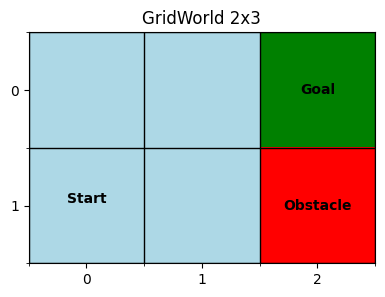

In [ ]:
env = GridWorld2x3()
agent = QLearningAgent(
    learning_rate=0.1,
    discount_factor_gamma=0.9,
    exploration_rate_epsilon=0.5,
    state_shape=env.grid.shape,
)

print("Reward grid:\n", env.grid)
plot_grid(env, agent=None, show_coords=False)

In [661]:
print(env.grid)

[[ 0.  0.  1.]
 [ 0.  0. -1.]]


In [662]:
episodes = 500

previous_episode_q_table = agent.q_table.copy()

for episode in range(1, episodes + 1):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.update_q_value(state, action, reward, next_state, done)
        state = next_state

    if np.allclose(previous_episode_q_table, agent.q_table):
        print(f"Q-table converged at episode {episode}")
        break

    previous_episode_q_table = agent.q_table.copy()

    print("##### Q-Table after episode: ", episode)
    agent.print_q_table()

##### Q-Table after episode:  1
State (x,y) |    UP    |  RIGHT   |   DOWN   |   LEFT  
-------------------------------------------------------
(0,0)      |    0.000 |    0.000 |    0.000 |    0.000
(1,0)      |    0.000 |    0.100 |    0.000 |    0.000
(2,0)      |    0.000 |    0.000 |    0.000 |    0.000
(0,1)      |    0.000 |    0.000 |    0.000 |    0.000
(1,1)      |    0.000 |    0.000 |    0.000 |    0.000
(2,1)      |    0.000 |    0.000 |    0.000 |    0.000
##### Q-Table after episode:  2
State (x,y) |    UP    |  RIGHT   |   DOWN   |   LEFT  
-------------------------------------------------------
(0,0)      |    0.000 |    0.009 |    0.000 |    0.000
(1,0)      |    0.000 |    0.190 |    0.000 |    0.000
(2,0)      |    0.000 |    0.000 |    0.000 |    0.000
(0,1)      |    0.000 |    0.000 |    0.000 |    0.000
(1,1)      |    0.000 |    0.000 |    0.000 |    0.000
(2,1)      |    0.000 |    0.000 |    0.000 |    0.000
##### Q-Table after episode:  3
State (x,y) |    UP 

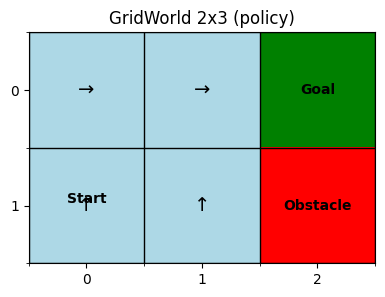

Greedy path: (0,1) -> (0,0) -> (1,0) -> (2,0)
Final reward: 1.0 | done: True


In [663]:
plot_grid(env, agent=agent, show_coords=False)  # show learned policy
run_greedy_episode(env, agent)